In [106]:
include("../src/vafdyn.jl")
include("../src/vafSim.jl")
using .VAFDyn
using .VAFSim

In [96]:
using ProgressMeter
using JLD2

In [3]:
using LaTeXStrings
using Plots
gr()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


Plots.GRBackend()

In [82]:
params = Dict(
    "N"=>200,
    "ρ"=>1.,
    "ϕ"=>4.,
    "μ"=>5.0,
    "S"=>50,
)

function extendParams(params)
    params["λ"] = params["ρ"]+params["ϕ"]
    params["p"] = params["ϕ"]/params["λ"]
end

extendParams(params)

evolveTime = 40

display(params)

Dict{String,Real} with 7 entries:
  "μ" => 5.0
  "S" => 50
  "λ" => 5.0
  "N" => 200
  "ρ" => 1.0
  "ϕ" => 4.0
  "p" => 0.8

In [83]:
# === expected value evolve ===
dfs = VAFDyn.DFreqspace(params["N"])
@time VAFDyn.evolveVAF(dfs, params, evolveTime);


  0.052237 seconds (16.59 k allocations: 1.668 MiB)


In [120]:
nEq_f = ((2params["ρ"]+params["ϕ"])/params["ρ"])*params["μ"] ./ dfs.freqs_f[2:end-1];


In [125]:
# === Sampling ev evolve ===

# dfsS = VAFDyn.sampler(dfs, params["S"])
nSEq_f = VAFDyn.sampler( ((2params["ρ"]+params["ϕ"])/params["ρ"])*params["μ"] ./ dfs.freqs_f, params["N"], params["S"])[2:end-1]

49-element Array{Float64,1}:
 5999.999999999999
 2999.999999999999
 2000.0000000000005
 1500.0
 1200.0000000000002
  999.9999999999999
  857.1428571428569
  749.9999999999998
  666.6666666666665
  600.0
  545.4545454545455
  499.99999999999994
  461.53846153846143
    ⋮
  157.89473684210526
  153.84615384615387
  150.0
  146.3414634146341
  142.85714285714283
  139.5348837209302
  136.36363636363632
  133.33333333333334
  130.43478260869566
  127.65957446808514
  124.99999999999997
  122.44897959183669

In [88]:
# === Single simulation ===
@time nSim_f, nSimS_f, _, _, _ = 
    VAFSim.birthDeathAlt(params["N"], params["μ"], params["p"], params["S"], evolveTime, params["λ"])

 23.558884 seconds (843.97 k allocations: 19.634 GiB, 15.19% gc time)


([0, 5699, 3068, 2447, 1046, 1156, 157, 3278, 569, 640  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [7181, 8204, 3440, 1755, 648, 131, 487, 778, 127, 48  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, 24331, [1108, 1027, 1158, 1106, 1013, 1184, 1153, 1187, 1169, 1128  …  1163, 1191, 1164, 1261, 1120, 1176, 1217, 1157, 1120, 1152])

In [159]:
# === ensemble sims ===

nSims = 500

nSim_f_sim = zeros(Float64, params["N"]+1, nSims)
nSimS_f_sim = zeros(Float64, params["S"]+1, nSims)

@showprogress for i in 1:nSims
    
    nSim_f, nSimS_f, _, _, _ = 
        VAFSim.birthDeathAlt(params["N"], params["μ"], params["p"], params["S"], evolveTime, params["λ"])
    
    nSim_f_sim[:, i] .= nSim_f
    nSimS_f_sim[:, i] .= nSimS_f
    
end
nSimAv_f = sum(nSim_f_sim, dims=2) / nSims
nSimSAv_f = sum(nSimS_f_sim, dims=2) / nSims

@save "vafSimsBottleneck.jld2" params nSimAv_f nSimSAv_f

Progress: 100%|█████████████████████████████████████████| Time: 3:09:19


In [166]:
gr()

Plots.GRBackend()

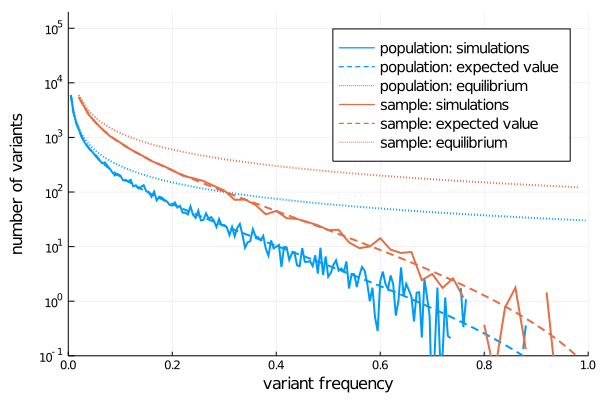

In [172]:
# plotting
# palette([:roma, ])

p1 = plot(dfs.freqs_f[2:end-1], nSimAv_f[2:end-1],
    yaxis=:log10,
    label="population: simulations", 
    color=1,
    linewidth=2)

plot!(dfs.freqs_f[2:end-1], dfs.n_f[2:end-1],
    label="population: expected value",
    linewidth=2,
#     size=(500,360),
    legendfontsize=10,
    labelfontsize=11,
    color=1,
    linestyle=:dash,
    color_palette=:default)

plot!(dfs.freqs_f[2:end-1], nEq_f,
    label="population: equilibrium",
    color=1,
    linewidth=2,
    linestyle=:dot)


plot!(dfsS.freqs_f[2:end-1], nSimSAv_f[2:end-1],
    label="sample: simulations",
    color=2,
    linewidth=2)

plot!(dfsS.freqs_f[2:end-1], dfsS.n_f[2:end-1],
    label="sample: expected value",
    linewidth=2,
    color=2,
    linestyle=:dash)

plot!(dfsS.freqs_f[2:end-1], nSEq_f,
    label="sample: equilibrium",
    color=2,
    linewidth=2,
    linestyle=:dot)

xlims!((0, 1))
ylims!((10^-1, 2*10^5))
xlabel!("variant frequency")
ylabel!("number of variants")
display(p1)

# plot!(h, sampledfs.freqs_f[2:end], sampledfs.n_f[2:end], label="sampled", yaxis=:log10)
# display(h)

savefig("../figures/VAFSampling.pdf")